In [1]:
import matplotlib.pyplot as plt
#import seaborn as sns
import json
import spacy
import random
import re
import pandas as pd
from spacy.tokenizer import Tokenizer
from spacy.util import minibatch, compounding
from spacy.training.example import Example
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from spacy.scorer import Scorer
from thinc.api import Adam

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
import scispacy
nlp = spacy.load("/home/mmbaye/en_core_sci_lg-0.5.4", disable=["tagger", "parser", "attribute_ruler", "lemmatizer"])
if "ner" in nlp.pipe_names:
    nlp.remove_pipe("ner")

In [9]:
ner = nlp.add_pipe("ner")

# ner = nlp.get_pipe("ner")
labels = [
    "RECEPT_ID", "SPECIFITY", "MAB_SPECIES", "CHAIN_TYPE", "CHAIN_SPECIES",
    "DOMAIN_TYPE", "GENE", "ALLELE", "MUTATION", "ALLOTYPE", "CDR_IMGT", 
    "HINGE_REGION", "SPECIFITY_CLASS", "BRIDGE", "CONJUGATE", 
    "FUSED", "PRODUCTION_SYSTEME", "MOA"
]
for label in labels:
    ner.add_label(label)

In [10]:
nlp.pipe_names

['tok2vec', 'ner']

In [11]:
nlp.get_pipe('ner').labels

('ALLELE',
 'ALLOTYPE',
 'BRIDGE',
 'CDR_IMGT',
 'CHAIN_SPECIES',
 'CHAIN_TYPE',
 'CONJUGATE',
 'DOMAIN_TYPE',
 'FUSED',
 'GENE',
 'HINGE_REGION',
 'MAB_SPECIES',
 'MOA',
 'MUTATION',
 'PRODUCTION_SYSTEME',
 'RECEPT_ID',
 'SPECIFITY',
 'SPECIFITY_CLASS')

In [12]:
def del_overlaps(entites):
    """
    Supprime les entités chevauchantes en gardant la première occurrence.
    """
    entites.sort(key=lambda x: x[0])
    non_overlapped = []
    derniere_fin = -1

    for debut, fin, etiquette in entites:
        if debut >= derniere_fin:
            non_overlapped .append((debut, fin, etiquette))
            derniere_fin = fin

    return non_overlapped

In [13]:
with open("/home/mmbaye/myscratch/Training_Models/spacy_models/bc5cdr_ner_model/train_set.json", "r", encoding="utf-8") as f:
    train_set = json.load(f)
print(f"train: {train_set[0]}")
with open("/home/mmbaye/myscratch/Training_Models/spacy_models/bc5cdr_ner_model/test_set.json", "r", encoding="utf-8") as f:
    test_set = json.load(f)
print(f"test: {test_set[0]}")

train: ['N2.1,N6.Lys-oligo(N-{2-[o-methoxypoly(oxyethylene)-a-yl]acetyl}-N-[a-methylpoly(oxyethylene)-o-yl]glycyl)human interferon alpha-2b, with an average number of 5 substituted among 11 amino groups (one N-terminal and 10 lysine N6), the protein part being produced in Pichia pastoris (Komagataella pastoris) The relative molecular mass of the polyethylene glycol part can be indicated after the INN, for example: mipeginterferon alfa-2b (40 kDa) immunomodulator', {'entities': [[252, 281, 'PRODUCTION_SYSTEME'], [442, 457, 'MOA']]}]
test: ['immunoglobulin G4-kappa, anti-[Homo sapiens PDCD1 (programmed cell death 1, PD-1, PD1, CD279)], humanized monoclonal antibody; gamma4 heavy chain humanized (1-446) [VH (Homo sapiens IGHV3-23*04 (86.7%) -(IGHD) -IGHJ4*01 (100%)) [8.8.13] (1-120)-Homo sapiens IGHG4*01, G4v5 h P10 (CH1 (121-218), hinge 1-12 S10>P (228) (219-230), CH2 (231-340), CH3 (341-445), CHS K2>del (446)) (121-446)], (134-218\')-disulfide with kappa light chain humanized (1\'-218\'

In [17]:
# Configuration
n_iter = 20
batch_size = 2
drop_rate = 0.5

# Définir tokenizer personnalisé
prefix_re = re.compile(r'''^[\[\(\]\)"',]''')
suffix_re = re.compile(r'''[\]\)\[\("',;]$''')
infix_re = re.compile(r'''(?:[>])|[\]\)\[\(\;',']''')  # Correction ici

# Appliquer le tokenizer personnalisé
nlp.tokenizer = Tokenizer(
    nlp.vocab,
    prefix_search=prefix_re.search,
    suffix_search=suffix_re.search,
    infix_finditer=infix_re.finditer
)

# Créer un optimiseur manuellement
optimizer = Adam(learn_rate=0.001)

# Entraînement du modèle
with nlp.disable_pipes([pipe for pipe in nlp.pipe_names if pipe not in ("tok2vec", "ner")]):
    ner = nlp.get_pipe("ner")  # Obtenir le modèle NER

    for iteration in range(n_iter):
        print(f"Début de l'itération {iteration}")
        
      
        random.shuffle(train_set)
        
        losses = {}  
        for text, annotations in train_set:
            # Vérifier les données textuelles invalides
            if pd.isna(text) or not isinstance(text, str):
                print("Skipping invalid text data in training example")
                continue
            
            doc = nlp.make_doc(text)
            
            # Suppression des entités qui se chevauchent (assurez-vous que del_overlaps est défini)
            if 'entities' in annotations:
                annotations['entities'] = del_overlaps(annotations['entities'])
            
            # Créer un exemple SpaCy à partir des données textuelles et des annotations
            example = Example.from_dict(doc, annotations)
            
            try:
                # Mise à jour du modèle avec cet exemple
                nlp.update([example], drop=drop_rate, sgd=optimizer, losses=losses)
            except Exception as e:
                print(f"Erreur lors de la mise à jour du modèle : {e}")
        
        # Afficher les pertes à la fin de l'itération
        print(f"Pertes à la fin de l'itération {iteration}: {losses}")

# Sauvegarder le modèle entraîné
save_path = "/home/mmbaye/myscratch/Training_Models/spacy_models/sci_lg_ner_model"
nlp.to_disk(save_path)
print(f"Modèle enregistré dans {save_path}")


Début de l'itération 0
Pertes à la fin de l'itération 0: {'tok2vec': 0.0, 'ner': 14241.118657846151}
Début de l'itération 1
Pertes à la fin de l'itération 1: {'tok2vec': 0.0, 'ner': 12622.490243101367}
Début de l'itération 2
Pertes à la fin de l'itération 2: {'tok2vec': 0.0, 'ner': 11780.748740310632}
Début de l'itération 3
Pertes à la fin de l'itération 3: {'tok2vec': 0.0, 'ner': 11516.541564176618}
Début de l'itération 4
Pertes à la fin de l'itération 4: {'tok2vec': 0.0, 'ner': 11185.12632710267}
Début de l'itération 5
Pertes à la fin de l'itération 5: {'tok2vec': 0.0, 'ner': 10657.978811431869}
Début de l'itération 6
Pertes à la fin de l'itération 6: {'tok2vec': 0.0, 'ner': 10470.123403610349}
Début de l'itération 7
Pertes à la fin de l'itération 7: {'tok2vec': 0.0, 'ner': 10494.90160273219}
Début de l'itération 8
Pertes à la fin de l'itération 8: {'tok2vec': 0.0, 'ner': 9985.073941294671}
Début de l'itération 9
Pertes à la fin de l'itération 9: {'tok2vec': 0.0, 'ner': 9927.07206163

In [18]:
# Define your evaluate function if not already defined
nlp= spacy.load("/home/mmbaye/myscratch/Training_Models/spacy_models/sci_lg_ner_model")
def evaluate(nlp, data):
    examples = []
    for text, annotations in data:
        doc = nlp.make_doc(text)
        
        annotations['entities'] = del_overlaps(annotations['entities'])
        example = Example.from_dict(doc, annotations)
        examples.append(example)
    return nlp.evaluate(examples)

print("Évaluation sur l'ensemble de validation:")
# Call evaluate instead of evaluer
val_scores = evaluate(nlp, test_set)
print(val_scores)

Évaluation sur l'ensemble de validation:
{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'tag_acc': None, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'lemma_acc': None, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 0.7204934634505616, 'ents_r': 0.7181134153055606, 'ents_f': 0.7193014705882353, 'ents_per_type': {'RECEPT_ID': {'p': 0.3502994011976048, 'r': 0.468, 'f': 0.4006849315068493}, 'SPECIFITY': {'p': 0.3183023872679045, 'r': 0.40816326530612246, 'f': 0.35767511177347244}, 'MAB_SPECIES': {'p': 0.5960912052117264, 'r': 0.8798076923076923, 'f': 0.7106796116504855}, 'CHAIN_SPECIES': {'p': 0.9259259259259259, 'r': 0.9423503325942351, 'f': 0.9340659340659341}, 'ALLOTYPE': {'p': 0.66, 'r': 0.6387096774193548, 'f': 0.6491803278688524}, 'MUTATION': {'p': 0.6177105831533477, 'r': 0.5801217038539553, 'f': 0.59832635

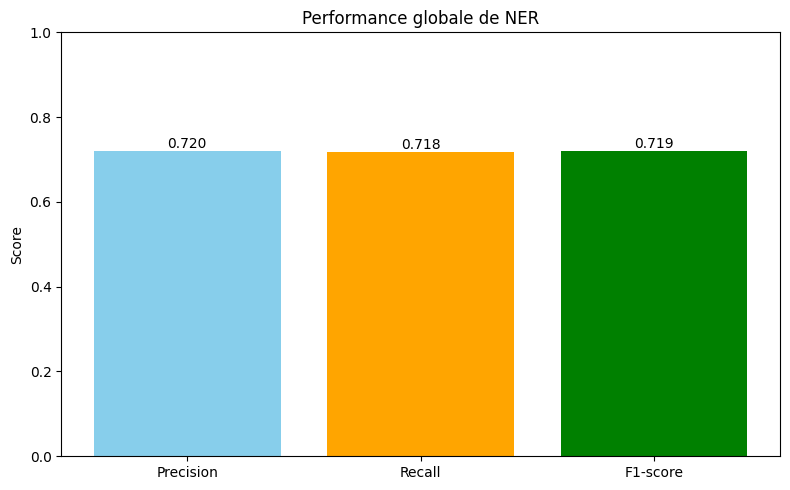

In [19]:
def plot_overall_performance(scores):
    """Affiche les scores globaux de NER (Precision, Recall, F1-score)."""
    metrics = ['ents_p', 'ents_r', 'ents_f']
    labels = ['Precision', 'Recall', 'F1-score']
    values = [scores[m] for m in metrics]
    colors = ['skyblue', 'orange', 'green']

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=colors)
    plt.ylim(0, 1)
    plt.title('Performance globale de NER')
    plt.ylabel('Score')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
plot_overall_performance(val_scores)

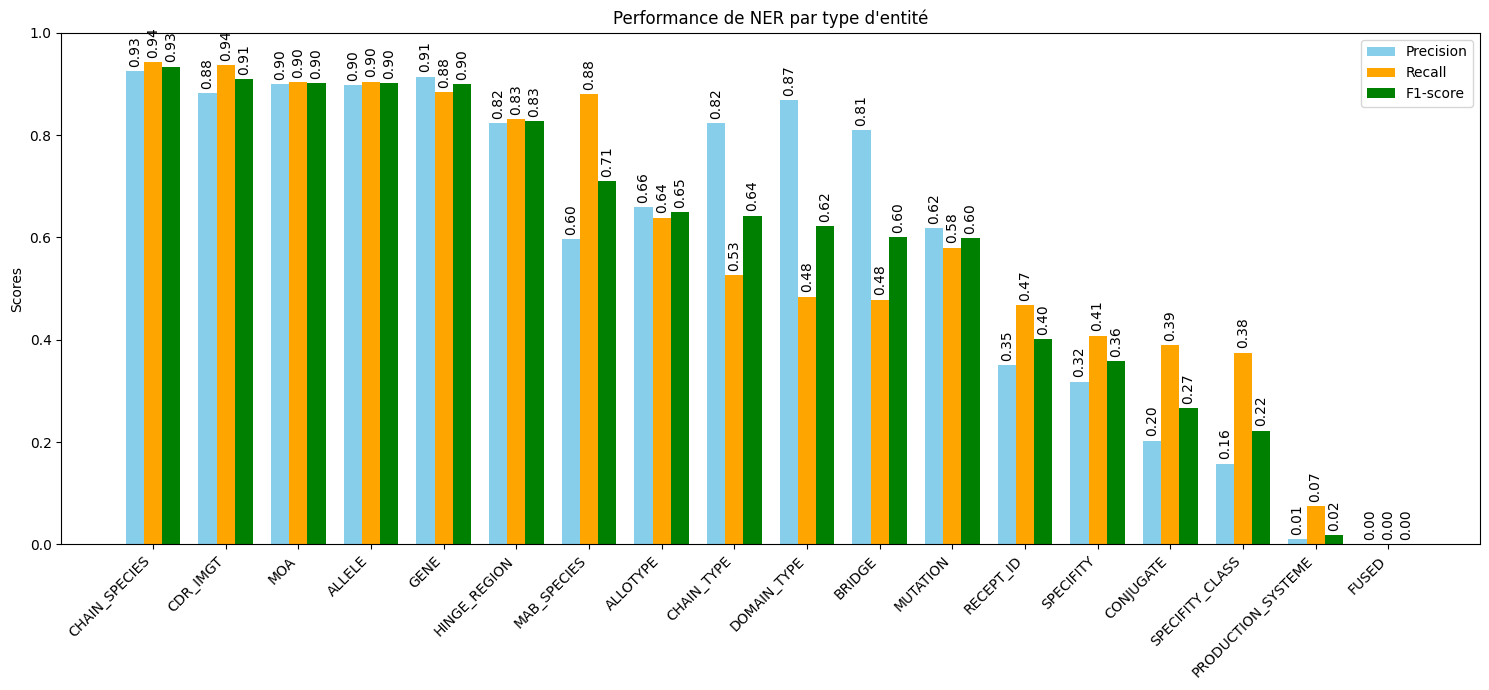

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entity_performance(scores):
    """Affiche les scores (P, R, F1) par type d’entité triés par F1-score décroissant."""
    ents = scores.get('ents_per_type', {})
    entity_types = list(ents.keys())
    precision = [ents[e].get('p', 0.0) for e in entity_types]
    recall = [ents[e].get('r', 0.0) for e in entity_types]
    f1 = [ents[e].get('f', 0.0) for e in entity_types]

    # Tri par F1-score décroissant
    sorted_indices = np.argsort(f1)[::-1]
    entity_types = [entity_types[i] for i in sorted_indices]
    precision = [precision[i] for i in sorted_indices]
    recall = [recall[i] for i in sorted_indices]
    f1 = [f1[i] for i in sorted_indices]

    x = np.arange(len(entity_types))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
    rects2 = ax.bar(x, recall, width, label='Recall', color='orange')
    rects3 = ax.bar(x + width, f1, width, label='F1-score', color='green')

    ax.set_ylabel('Scores')
    ax.set_title('Performance de NER par type d\'entité')
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()

    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', 
                        xy=(rect.get_x() + rect.get_width()/2, height), 
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

    fig.tight_layout()
    plt.show()
plot_entity_performance(val_scores)

In [22]:
import spacy
from spacy import displacy

# Charger le modèle pré-entrainé
nlp = spacy.load("/home/mmbaye/myscratch/Training_Models/spacy_models/sci_lg_ner_model")

# Texte d'exemple
text = """
immunoglobulin G1-kappa, anti-[rabies virus glycoprotein], Homo sapiens monoclonal antibody; gamma1 heavy chain (1-448) [Homo sapiens VH (IGHV3-33*03 (95.90%) -(IGHD)-IGHJ4*01) [8.8.12] (1-119) -IGHG1*03, CH3 K130>del (120-448)], (222-214')-disulfide with kappa light chain (1'-214') [Homo sapiens V-KAPPA (IGKV1-17*01 (95.80%) -IGKJ4*01) [6.3.9] (1'-107') -IGKC*01 (108'-214')]; (228-228'':231-231'')-bisdisulfide dimer
"""

# Appliquer le modèle sur le texte
doc = nlp(text)

# Afficher les entités détectées
for ent in doc.ents:
    print(ent.text, ent.label_)

# Visualiser les entités dans le Jupyter notebook
displacy.render(doc, style="ent", jupyter=True)


immunoglobulin G1-kappa RECEPT_ID
anti-[rabies virus glycoprotein], SPECIFITY
Homo sapiens MAB_SPECIES
gamma1 heavy chain CHAIN_TYPE
Homo sapiens CHAIN_SPECIES
VH DOMAIN_TYPE
IGHV3-33*03 ALLELE
IGHD GENE
-IGHJ4*01 ALLELE
-IGHG1*03 ALLELE
CH3 DOMAIN_TYPE
K130>del MUTATION
Homo sapiens CHAIN_SPECIES
V-KAPPA DOMAIN_TYPE
IGKV1-17*01 ALLELE
-IGKJ4*01 ALLELE
-IGKC*01 ALLELE
-bisdisulfide BRIDGE


ImportError: cannot import name 'display' from 'IPython.core.display' (/srv/scratch/mmbaye/spacy_env/lib/python3.11/site-packages/IPython/core/display.py)